In [13]:
import os, sys, math, json, glob, random, time, collections, subprocess
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import jiwer  # for WER/CER

# Import Mamba
try:
    from mamba_ssm import Mamba
    print("✓ Mamba imported successfully")
except ImportError as e:
    print(f"✗ Failed to import Mamba: {e}")
    print("Please ensure mamba-ssm is installed correctly")

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Check all available GPUs
if torch.cuda.is_available():
    n_gpus = torch.cuda.device_count()
    print(f"\n{'='*60}")
    print(f"🚀 FOUND {n_gpus} GPUs!")
    print(f"{'='*60}")
    for i in range(n_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"{'='*60}\n")
    
    try:
        gpu_info = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=name,memory.total", "--format=csv,noheader"]
        ).decode().strip()
        print("Detailed GPU info:")
        for i, line in enumerate(gpu_info.split('\n')):
            print(f"  GPU {i}: {line}")
    except Exception as e:
        print("Could not get detailed GPU info:", e)

✓ Mamba imported successfully
Torch version: 2.4.0+cu121
CUDA available: True
Using device: cuda

🚀 FOUND 8 GPUs!
GPU 0: NVIDIA A40
GPU 1: NVIDIA A40
GPU 2: NVIDIA A40
GPU 3: NVIDIA A40
GPU 4: NVIDIA A40
GPU 5: NVIDIA A40
GPU 6: NVIDIA A40
GPU 7: NVIDIA A40

Detailed GPU info:
  GPU 0: NVIDIA A40, 46068 MiB
  GPU 1: NVIDIA A40, 46068 MiB
  GPU 2: NVIDIA A40, 46068 MiB
  GPU 3: NVIDIA A40, 46068 MiB
  GPU 4: NVIDIA A40, 46068 MiB
  GPU 5: NVIDIA A40, 46068 MiB
  GPU 6: NVIDIA A40, 46068 MiB
  GPU 7: NVIDIA A40, 46068 MiB


In [3]:
INPUT_DIR = Path("./data")

if not INPUT_DIR.exists():
    # Try Kaggle path as fallback
    INPUT_DIR = Path("/kaggle/input/brain-to-text-25")
    
assert INPUT_DIR.exists(), f"Input not found: {INPUT_DIR}"
print(f"✓ Input root exists at: {INPUT_DIR}")

# Find all .hdf5 files
hdf5_files = sorted(INPUT_DIR.rglob("*.hdf5"))
print(f"Found {len(hdf5_files)} .hdf5 files")

print("\nTop-level folders:")
for d in INPUT_DIR.iterdir():
    if d.is_dir():
        print("-", d.name)

# Explore sample file
if hdf5_files:
    sample_file = hdf5_files[0]
    print(f"\nUsing sample file: {sample_file.relative_to(INPUT_DIR)}")
    with h5py.File(sample_file, "r") as hf:
        print("Top-level keys:", list(hf.keys())[:5], f"... (total: {len(hf.keys())})")
        if len(hf.keys()) > 0:
            g0 = list(hf.keys())[0]
            print("Example group:", g0, "->", list(hf[g0].keys()))


✓ Input root exists at: data
Found 127 .hdf5 files

Top-level folders:
- hdf5_data_final
- t15_pretrained_rnn_baseline
- __MACOSX

Using sample file: hdf5_data_final/t15.2023.08.11/data_train.hdf5
Top-level keys: ['trial_0000', 'trial_0001', 'trial_0002', 'trial_0003', 'trial_0004'] ... (total: 288)
Example group: trial_0000 -> ['input_features', 'seq_class_ids', 'transcription']


In [5]:
# ============================================================================
# SECTION 3: Data Indexing Functions (OPTIMIZED - NO MEMORY CRASH)
# ============================================================================

def index_split_files(root: Path):
    """Index train/val/test split files - FAST VERSION"""
    print("Searching for data files...")
    split_map = {"train": [], "val": [], "test": []}
    
    # Use glob instead of rglob for speed if files are in root
    for fp in root.glob("**/*.hdf5"):
        name = fp.name
        if "train" in name.lower():
            split_map["train"].append(fp)
        elif "val" in name.lower():
            split_map["val"].append(fp)
        elif "test" in name.lower():
            split_map["test"].append(fp)
    
    for k in split_map:
        split_map[k] = sorted(split_map[k])
    
    print(f"Found: Train={len(split_map['train'])}, Val={len(split_map['val'])}, Test={len(split_map['test'])}")
    return split_map

def build_index_fast(file_list, max_files=None):
    """Build dataframe index - MEMORY EFFICIENT VERSION"""
    if not file_list:
        print("⚠ No files to index!")
        return pd.DataFrame(columns=["file", "trial"])
    
    # Limit files for testing
    if max_files:
        file_list = file_list[:max_files]
        print(f"⚠ LIMITING to first {max_files} files for testing")
    
    rows = []
    print(f"Indexing {len(file_list)} files...")
    
    for i, fp in enumerate(file_list):
        print(f"  [{i+1}/{len(file_list)}] {fp.name} ", end="", flush=True)
        try:
            with h5py.File(fp, "r") as hf:
                # Just count keys, don't load data
                trial_count = 0
                for k in list(hf.keys()):  # Convert to list to avoid iterator issues
                    g = hf[k]
                    if "input_features" in g and "transcription" in g:
                        rows.append({"file": str(fp), "trial": k})
                        trial_count += 1
                print(f"({trial_count} trials)", flush=True)
        except Exception as e:
            print(f"✗ ERROR: {e}", flush=True)
            continue
    
    df = pd.DataFrame(rows)
    print(f"\n✓ Indexed {len(df)} total trials")
    return df

# Build train/val indices
print("\n" + "="*60)
print("INDEXING DATA FILES")
print("="*60)

split_files = index_split_files(INPUT_DIR)

if not split_files["train"]:
    print("\n⚠ WARNING: No training files found!")
    print("Checking what files exist in data directory:")
    all_files = list(INPUT_DIR.glob("**/*.hdf5"))
    for f in all_files[:10]:  # Show first 10
        print(f"  - {f.relative_to(INPUT_DIR)}")
    print("\nExpected files like: data_train.hdf5 or train.hdf5")
    raise FileNotFoundError("No training data found!")

# OPTION: Limit files during testing
# Uncomment the line below to only use first 2 files for quick testing
# MAX_FILES = 2  

print("\n📂 Indexing TRAIN data...")
train_df = build_index_fast(split_files["train"], max_files=None)  # Change to MAX_FILES for testing

print("\n📂 Indexing VALIDATION data...")
val_files = split_files["val"] if split_files["val"] else split_files["test"]
val_df = build_index_fast(val_files, max_files=None)  # Change to MAX_FILES for testing

print(f"\n{'='*60}")
print(f"✓ INDEXING COMPLETE")
print(f"{'='*60}")
print(f"Train trials: {len(train_df)}")
print(f"Val trials: {len(val_df)}")

if len(train_df) == 0:
    raise ValueError("No training trials found! Check your data files.")

print("\n📊 Train data sample:")
display(train_df.head(3))
print("\n📊 Val data sample:")
display(val_df.head(3))



INDEXING DATA FILES
Searching for data files...
Found: Train=45, Val=41, Test=41

📂 Indexing TRAIN data...
Indexing 45 files...
  [1/45] data_train.hdf5 (288 trials)
  [2/45] data_train.hdf5 (348 trials)
  [3/45] data_train.hdf5 (197 trials)
  [4/45] data_train.hdf5 (278 trials)
  [5/45] data_train.hdf5 (88 trials)
  [6/45] data_train.hdf5 (150 trials)
  [7/45] data_train.hdf5 (297 trials)
  [8/45] data_train.hdf5 (322 trials)
  [9/45] data_train.hdf5 (245 trials)
  [10/45] data_train.hdf5 (153 trials)
  [11/45] data_train.hdf5 (218 trials)
  [12/45] data_train.hdf5 (174 trials)
  [13/45] data_train.hdf5 (284 trials)
  [14/45] data_train.hdf5 (155 trials)
  [15/45] data_train.hdf5 (239 trials)
  [16/45] data_train.hdf5 (98 trials)
  [17/45] data_train.hdf5 (134 trials)
  [18/45] data_train.hdf5 (149 trials)
  [19/45] data_train.hdf5 (80 trials)
  [20/45] data_train.hdf5 (100 trials)
  [21/45] data_train.hdf5 (60 trials)
  [22/45] data_train.hdf5 (198 trials)
  [23/45] data_train.hdf5 

,file,trial
0,data/hdf5_data_final/t15.2023.08.11/data_train...,trial_0000
1,data/hdf5_data_final/t15.2023.08.11/data_train...,trial_0001
2,data/hdf5_data_final/t15.2023.08.11/data_train...,trial_0002



📊 Val data sample:


,file,trial
0,data/hdf5_data_final/t15.2023.08.13/data_val.hdf5,trial_0000
1,data/hdf5_data_final/t15.2023.08.13/data_val.hdf5,trial_0001
2,data/hdf5_data_final/t15.2023.08.13/data_val.hdf5,trial_0002


In [37]:
# ============================================================================
# SECTION 3: Data Indexing Functions (OPTIMIZED - NO MEMORY CRASH)
# ============================================================================

class BrainDataset(Dataset):
    """Dataset for brain neural recordings"""
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fp = row["file"]
        trial = row["trial"]
        with h5py.File(fp, "r") as hf:
            g = hf[trial]
            x = g["input_features"][()]  # shape (T, C)
            y = g["transcription"][()]   # shape (L,) int32
        
        # CRITICAL FIX: Remove padding zeros from transcription
        y = y[y != 0]  # Keep only non-zero tokens
        
        x = torch.tensor(x, dtype=torch.float32)  # [T, C]
        y = torch.tensor(y, dtype=torch.long)     # [L]
        return x, y

def collate_for_ctc(batch):
    """Collate function for CTC training"""
    xs, ys = zip(*batch)
    x_lens = [x.shape[0] for x in xs]
    t_lens = [y.shape[0] for y in ys]
    max_t = max(x_lens)
    channels = xs[0].shape[1]
    
    # Pad sequences
    x_padded = torch.zeros(len(xs), channels, max_t, dtype=torch.float32)
    for i, x in enumerate(xs):
        T = x.shape[0]
        x_padded[i, :, :T] = x.permute(1, 0)  # [C, T]
    
    # Concatenate targets
    targets_concat = torch.cat([y for y in ys]) if sum(t_lens) > 0 else torch.tensor([], dtype=torch.long)
    
    return (x_padded, targets_concat, 
            torch.tensor(x_lens, dtype=torch.long), 
            torch.tensor(t_lens, dtype=torch.long))

# Create data loaders
BATCH_SIZE = 8
NUM_WORKERS = 8

# MULTI-GPU: Increase batch size if using multiple GPUs
n_gpus = torch.cuda.device_count() if torch.cuda.is_available() else 1
if n_gpus > 1:
    BATCH_SIZE = BATCH_SIZE * n_gpus  # Scale batch size with number of GPUs
    print(f"🚀 Multi-GPU detected! Scaling batch size to {BATCH_SIZE}")

train_loader = DataLoader(
    BrainDataset(train_df), 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_for_ctc, 
    num_workers=NUM_WORKERS,
    pin_memory=True  # Faster GPU transfer
)

val_loader = DataLoader(
    BrainDataset(val_df), 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_for_ctc, 
    num_workers=NUM_WORKERS,
    pin_memory=True  # Faster GPU transfer
)

# Sanity check
bx, bt, blx, blt = next(iter(train_loader))
print(f"\n✓ Batch check - x: {bx.shape}, targets: {bt.shape}")
IN_CH = bx.shape[1]
print(f"✓ Input channels: {IN_CH}")

🚀 Multi-GPU detected! Scaling batch size to 64

✓ Batch check - x: torch.Size([64, 512, 1789]), targets: torch.Size([1919])
✓ Input channels: 512


In [38]:
# ============================================================================
# SECTION 5: Mamba Model Architecture
# ============================================================================

class ConvStem(nn.Module):
    """Convolutional stem for downsampling"""
    def __init__(self, in_ch, d_model):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, d_model // 2, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.Conv1d(d_model // 2, d_model, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
        )
    
    def forward(self, x):  # x: [B, C, T]
        return self.net(x)  # [B, D, T']

class MambaBlock(nn.Module):
    """Single Mamba block with residual connection"""
    def __init__(self, d_model, d_state=16, d_conv=4, expand=2):
        super().__init__()
        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
        )
        self.norm = nn.LayerNorm(d_model)
    
    def forward(self, x):
        # x: [B, L, D]
        return x + self.mamba(self.norm(x))

class MambaEncoder(nn.Module):
    """Mamba-based encoder for brain-to-text decoding"""
    def __init__(self, in_ch, d_model=256, n_layers=6, d_state=16, vocab_size=256):
        super().__init__()
        self.conv = ConvStem(in_ch, d_model)
        
        # Stack of Mamba blocks
        self.layers = nn.ModuleList([
            MambaBlock(d_model, d_state=d_state) 
            for _ in range(n_layers)
        ])
        
        self.norm = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, vocab_size)
    
    def forward(self, x):
        # x: [B, C, T]
        x = self.conv(x)           # [B, D, T']
        x = x.permute(0, 2, 1)     # [B, T', D]
        
        # Pass through Mamba blocks
        for layer in self.layers:
            x = layer(x)
        
        x = self.norm(x)           # [B, T', D]
        logits = self.fc(x)        # [B, T', V]
        return F.log_softmax(logits, dim=-1)

In [39]:
# ============================================================================
# SECTION 6: Decoding and Text Conversion
# ============================================================================

@torch.no_grad()
def greedy_decode_from_logprobs(log_probs, blank=0):
    """CTC greedy decoding"""
    # log_probs: [B, T, V]
    preds = log_probs.argmax(-1).cpu().numpy()  # [B, T]
    decoded = []
    for i in range(preds.shape[0]):
        seq = preds[i]
        # Remove consecutive duplicates and blanks
        seq_clean = [p for j, p in enumerate(seq) 
                     if (j == 0 or p != seq[j-1]) and p != blank]
        decoded.append(seq_clean)
    return decoded

def ids_to_text(id_list):
    """Convert token IDs to text"""
    chars = []
    for i in id_list:
        if 1 <= i <= 127:  # Valid ASCII range
            chars.append(chr(i))
    return "".join(chars)

In [40]:
# ============================================================================
# SECTION 7: Evaluation Function
# ============================================================================


def evaluate(model, loader, criterion, blank_id=0, max_batches=50):
    """Evaluate model on validation set"""
    model.eval()
    tot_loss, n_batches = 0.0, 0
    hyps, refs = [], []
    
    with torch.no_grad():
        for b, (x, targets, x_lens, t_lens) in enumerate(loader):
            x = x.to(device)  # [B, C, T]
            B, C, T = x.shape
            logp = model(x)   # [B, T', V]
            Tprime = logp.size(1)

            # Prepare for CTC: [T', B, V]
            logp_ctc = logp.permute(1, 0, 2)
            input_lengths = torch.full((B,), Tprime, dtype=torch.long, device=logp.device)
            target_lengths = t_lens.to(device)

            loss = criterion(logp_ctc, targets.to(device), input_lengths, target_lengths)
            tot_loss += loss.item()
            n_batches += 1

            # Decode predictions
            pred_ids_batch = greedy_decode_from_logprobs(logp, blank=blank_id)
            
            # Split concatenated targets back to sequences
            off = 0
            for i in range(B):
                L = t_lens[i].item()
                ref_ids = targets[off:off+L].tolist()
                off += L
                hyp_text = ids_to_text(pred_ids_batch[i])
                ref_text = ids_to_text(ref_ids)
                hyps.append(hyp_text)
                refs.append(ref_text)
            
            if b + 1 >= max_batches:
                break

    # Calculate WER and CER
    wer = jiwer.wer(refs, hyps) if refs else 0.0
    cer = jiwer.cer(refs, hyps) if refs else 0.0
    avg_loss = tot_loss / max(1, n_batches)
    
    return avg_loss, wer, cer

In [41]:
# ============================================================================
# SECTION 8: Training Loop (MULTI-GPU OPTIMIZED)
# ============================================================================

def train_loop(model, train_loader, val_loader, epochs=5, lr=2e-4, blank_id=0):
    """Main training loop with multi-GPU support"""
    
    # Multi-GPU wrapper
    n_gpus = torch.cuda.device_count() if torch.cuda.is_available() else 1
    if n_gpus > 1:
        print(f"\n{'='*60}")
        print(f"🚀 ENABLING MULTI-GPU TRAINING on {n_gpus} GPUs!")
        print(f"{'='*60}\n")
        model = nn.DataParallel(model)
    
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    scaler = GradScaler(enabled=(device=='cuda'))
    criterion = nn.CTCLoss(blank=blank_id, zero_infinity=True)

    train_losses, val_losses, val_wers, val_cers = [], [], [], []

    for ep in range(1, epochs+1):
        model.train()
        running = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {ep}/{epochs}")
        
        for batch_idx, (x, targets, x_lens, t_lens) in enumerate(pbar):
            x = x.to(device, non_blocking=True)  # Async GPU transfer
            targets = targets.to(device, non_blocking=True)
            t_lens = t_lens.to(device, non_blocking=True)
            
            B, C, T = x.shape
            
            # Forward pass
            with torch.amp.autocast(device_type='cuda', enabled=(device=="cuda")):
                logp = model(x)  # [B, T', V]
                Tprime = logp.size(1)

                # Prepare for CTC: [T', B, V]
                logp_ctc = logp.permute(1, 0, 2)
                input_lengths = torch.full((B,), Tprime, dtype=torch.long, device=logp.device)

                loss = criterion(logp_ctc, targets, input_lengths, t_lens)

            # Backward pass
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running += loss.item()
            
            # Enhanced progress bar with GPU memory
            if torch.cuda.is_available():
                gpu_mem = torch.cuda.memory_allocated() / 1024**3
                pbar.set_postfix(loss=f"{loss.item():.4f}", gpu_mem=f"{gpu_mem:.1f}GB")
            else:
                pbar.set_postfix(loss=f"{loss.item():.4f}")

        train_loss = running / max(1, len(train_loader))
        
        # Unwrap model for evaluation if using DataParallel
        eval_model = model.module if isinstance(model, nn.DataParallel) else model
        val_loss, val_wer, val_cer = evaluate(eval_model, val_loader, criterion, 
                                               blank_id=blank_id, max_batches=50)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_wers.append(val_wer)
        val_cers.append(val_cer)

        print(f"[Epoch {ep}] train_loss={train_loss:.4f} | "
              f"val_loss={val_loss:.4f} | WER={val_wer:.3f} | CER={val_cer:.3f}")

    return train_losses, val_losses, val_wers, val_cers


In [42]:
# ============================================================================
# SECTION 9: Visualization Functions
# ============================================================================

def plot_metrics(train_losses, val_losses, val_wers=None, val_cers=None):
    """Plot training metrics"""
    epochs = range(1, len(train_losses)+1)
    
    if val_wers is not None and val_cers is not None:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes = list(axes)
    
    # Loss plot
    axes[0].plot(epochs, train_losses, marker='o', label='Train Loss')
    axes[0].plot(epochs, val_losses, marker='o', label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('CTC Loss')
    axes[0].legend()
    axes[0].set_title('Training and Validation Loss')
    axes[0].grid(True, alpha=0.3)
    
    # WER plot
    if val_wers is not None:
        axes[1].plot(epochs, val_wers, marker='o', color='orange', label='Val WER')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('WER')
        axes[1].legend()
        axes[1].set_title('Word Error Rate')
        axes[1].grid(True, alpha=0.3)
    
    # CER plot
    if val_cers is not None:
        axes[2].plot(epochs, val_cers, marker='o', color='green', label='Val CER')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('CER')
        axes[2].legend()
        axes[2].set_title('Character Error Rate')
        axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

@torch.no_grad()
def preview_predictions(model, loader, n_batches=1, blank_id=0):
    """Preview model predictions"""
    model.eval()
    cnt = 0
    for x, targets, x_lens, t_lens in loader:
        x = x.to(device)
        logp = model(x)
        hyps = greedy_decode_from_logprobs(logp, blank=blank_id)
        
        off = 0
        for i in range(x.size(0)):
            L = t_lens[i].item()
            ref_ids = targets[off:off+L].tolist()
            off += L
            hyp_text = ids_to_text(hyps[i])
            ref_text = ids_to_text(ref_ids)
            
            print(f"\n{'='*60}")
            print(f"Sample {cnt*x.size(0) + i + 1}")
            print(f"{'='*60}")
            print(f"REFERENCE: {ref_text}")
            print(f"PREDICTED: {hyp_text}")
            
        cnt += 1
        if cnt >= n_batches:
            break

In [48]:
# ============================================================================
# SECTION 10: Model Creation and Training
# ============================================================================

VOCAB_SIZE = 256  # 0=blank, 1-255=tokens
D_MODEL = 512
N_LAYERS = 8
D_STATE = 16

print(f"\n{'='*60}")
print("Creating Mamba Model")
print(f"{'='*60}")
print(f"Input channels: {IN_CH}")
print(f"Model dimension: {D_MODEL}")
print(f"Number of layers: {N_LAYERS}")
print(f"State dimension: {D_STATE}")
print(f"Vocabulary size: {VOCAB_SIZE}")

model = MambaEncoder(
    in_ch=IN_CH,
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    d_state=D_STATE,
    vocab_size=VOCAB_SIZE
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Train the model
print(f"\n{'='*60}")
print("Starting Training")
print(f"{'='*60}")

EPOCHS = 30
LEARNING_RATE = 5e-5

train_losses, val_losses, val_wers, val_cers = train_loop(
    model, 
    train_loader, 
    val_loader, 
    epochs=EPOCHS, 
    lr=LEARNING_RATE, 
    blank_id=0
)


Creating Mamba Model
Input channels: 512
Model dimension: 512
Number of layers: 8
State dimension: 16
Vocabulary size: 256


/tmp/ipykernel_2612184/3638508355.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device=='cuda'))



Total parameters: 15,271,936
Trainable parameters: 15,271,936

Starting Training

🚀 ENABLING MULTI-GPU TRAINING on 8 GPUs!



Epoch 1/30:   0%|                                       | 0/127 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB. GPU 1 has a total capacity of 44.34 GiB of which 19.50 MiB is free. Process 57629 has 42.49 GiB memory in use. Including non-PyTorch memory, this process has 1.80 GiB memory in use. Of the allocated memory 1.22 GiB is allocated by PyTorch, and 111.26 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training Complete - Visualizing Results


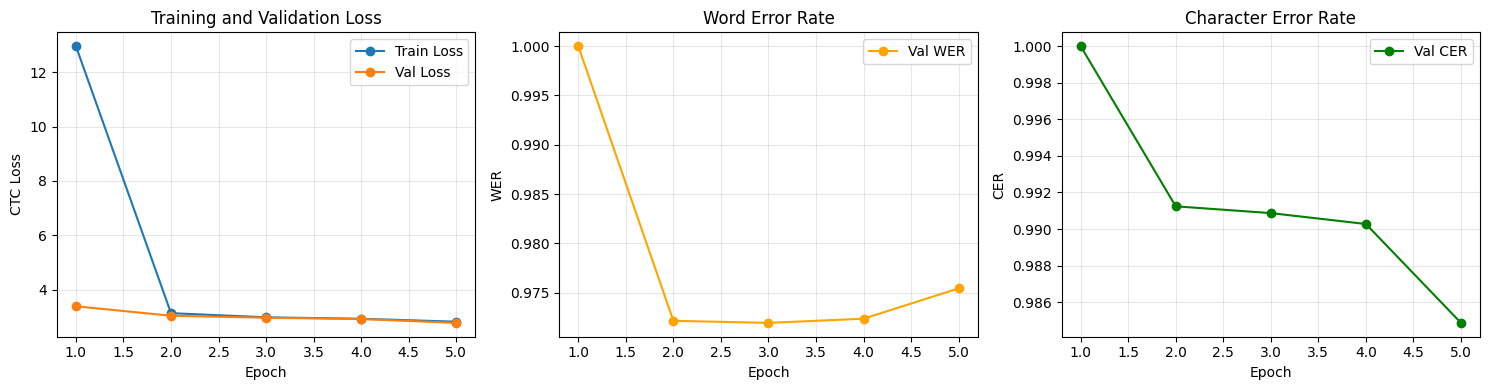


Sample Predictions

Sample 1
REFERENCE: You can see the code at this point as well.
PREDICTED: I 

Sample 2
REFERENCE: How does it keep the cost down?
PREDICTED: Is

Sample 3
REFERENCE: Not too controversial.
PREDICTED: I 

Sample 4
REFERENCE: The jury and a judge work together on it.
PREDICTED: I

Sample 5
REFERENCE: Were quite vocal about it.
PREDICTED: I

Sample 6
REFERENCE: He said the decision to part ways was mutual.
PREDICTED: I

Sample 7
REFERENCE: In fact this morning when they were talking.
PREDICTED: I 

Sample 8
REFERENCE: This is like a cruelty joke.
PREDICTED: Is

Sample 9
REFERENCE: Has such a high clay content.
PREDICTED: I 

Sample 10
REFERENCE: Woodworking mastery.
PREDICTED: I

Sample 11
REFERENCE: Wait a minute we know this thing isn't.
PREDICTED: I

Sample 12
REFERENCE: Up in New England where I'm from.
PREDICTED: I 

Sample 13
REFERENCE: One thing or the other.
PREDICTED: I

Sample 14
REFERENCE: He's one of the big proponents of that.
PREDICTED: I

Sample 15
REFE

In [44]:
# ============================================================================
# SECTION 11: Results Visualization
# ============================================================================

print(f"\n{'='*60}")
print("Training Complete - Visualizing Results")
print(f"{'='*60}")

plot_metrics(train_losses, val_losses, val_wers, val_cers)

# ============================================================================
# SECTION 12: Prediction Preview
# ============================================================================

print(f"\n{'='*60}")
print("Sample Predictions")
print(f"{'='*60}")

preview_predictions(model, val_loader, n_batches=2, blank_id=0)

# ============================================================================
# SECTION 13: Save Model (Optional)
# ============================================================================

print(f"\n{'='*60}")
print("Saving Model")
print(f"{'='*60}")

# Unwrap model if using DataParallel
save_model = model.module if isinstance(model, nn.DataParallel) else model

# Save model checkpoint
checkpoint_path = "mamba_brain2text_model.pt"
torch.save({
    'model_state_dict': save_model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_wers': val_wers,
    'val_cers': val_cers,
    'config': {
        'in_ch': IN_CH,
        'd_model': D_MODEL,
        'n_layers': N_LAYERS,
        'd_state': D_STATE,
        'vocab_size': VOCAB_SIZE,
    }
}, checkpoint_path)

print(f"✓ Model saved to {checkpoint_path}")
print(f"\nFinal Results:")
print(f"  Best Val Loss: {min(val_losses):.4f}")
print(f"  Best WER: {min(val_wers):.3f}")
print(f"  Best CER: {min(val_cers):.3f}")

print(f"\n{'='*60}")
print("TRAINING COMPLETE!")
print(f"{'='*60}")

# GPU Memory Summary
if torch.cuda.is_available():
    print(f"\n📊 GPU Memory Summary:")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.memory_allocated(i)/1024**3:.2f}GB / "
              f"{torch.cuda.get_device_properties(i).total_memory/1024**3:.2f}GB")